In [1]:
#Librerias de matplotli
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d #Esto es para realizar gráficas en 3D
import pandas as pd 
import numpy as np 
import scipy as sci 
import sympy as sp
from scipy.interpolate import interp1d,splrep,splev #Esto es para poder realizar la interpolación 
#Para realizar la cinemática de multicuerpos
from pytransform3d import rotations as pr_rot
from pytransform3d import plot_utils as pr_plot
import pytransform3d.transformations as pr_trans
import math as mt

# Hay-Stack Radiotelescope UIS 

Para el diseño mecánico de la estructura, y dimensionamiento del sistema de potencia del radiotelescopio Hay-Stack UIS es importante determinar el estado de cargas en cada uno de los sistemas coordenados correspondientes a cada sistema principal de la antena, por esta razón se presentará el estado de cargas para: 

1. Antena {C}                            $\rightarrow$ Frame $ \{O_c, x_c,y_c,z_c\}$ 
2. Sistema de potencia de elevación {B}  $\rightarrow$  Stability Axis  $\{O_b,x_b,y_b,z_b\}$
3. Sistema de potencia de azimuth {A}    $\rightarrow$ Stability Axis $\{ O_a, x_a,y_a,z_a\}$
4. Sistema fijo {S}    $\rightarrow$ Stability Axis $\{ O_s, x_s,y_s,z_s\}$
5. Sistema {D} centro de gravedad de la antena   $\rightarrow$ Stability Axis $\{O_{cw}, x_{cw}, y_{cw},z_{cw}\}$



##### Descripción del Notebook

El objetivo principal del notebook es la determinación de cargas para diferentes configuraciones de la antena, a partir de las cargas de viento encontradas en ***V2_Wind Loading (Hay-Stack Radiotelescope)- Beta*** y las cargas de peso que puede tener la antena sin contra peso, con el fin de lograr esto se definiran funciones que permitan fácilitar el problema cinemático de la antena, estas funciones están basadas en el notebook ***Antenna Kinematics***

## Funciones de configuración y cinemática

#### Función para el cálculo de las matrices de transformación para Hay-Stack Radiotelescope 

La funcion Transf recibe tres argumentos:
1. **alpha** : El ángulo en grados del azimuth
2. **theta** : El ángulo en grados de la elevación
3. **Frame** : String que representa el frame del cual se está interesado en conocer las matrices de rotación

La función va a tener un retorno dependiendo del frame que se escoja, como se muestra a continuación

    if Frame == "A":
        Transform =[Rsa,T_sa,T_a]
    if Frame == "B":
        Transform = [Rab,T_ab,T_sb,T_b]
    if Frame == "C":
        Transform = [Rcb,T_cb,T_bc,T_ac,T_sc]
    if Frame == "D" = [R_cd,T_cd,T_bd]

In [2]:
                                #Funciones de transformación entre frames
def set_config(alpha,theta,Frame):
    alpha =(-1)*alpha
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    Transform = []
    #Matriz de rotación para el eje fijo 
    Rs = np.array([
        [0,0,1],
        [1,0,0],
        [0,1,0]
        ]
    ) 
    Rs = Rs.T
    ps = np.array([0,-0.5,-3])
    #Matriz de transformación para el marco de referencia fijo
    S_frame = pr_trans.transform_from(Rs,ps) 
    
    #Configuración inicial del sistema de potencia azimutal 
    #Matriz  de rotacion inicial de A respecto a S
    Rsa = np.eye(3)
    #Vector de posición en s de A 
    pa_s = [2.5,0,0]
    #Matriz de transformación de A2S
    T_sa = pr_trans.transform_from(Rsa,pa_s) 
    
    #Giro del eje azimutal
    #Vector de rotación (w,theta) expresado en coordenadas S
    a_azimuth = [1,0,0,alpha]
    Rot_az = pr_rot.matrix_from_axis_angle(a=a_azimuth)
    T_sa = pr_trans.rotate_transform(A2B=T_sa, R = Rot_az)
    #Matriz de transformación para gráficar T_a
    T_a = pr_trans.concat(T_sa,S_frame)
    
    #Configuración inicial del sistema de potencia de elevación 

    Rab = np.eye(3)
    #vector de posición de B expresada en coordenadas de A
    pb_a = [0.256,0,0]
    #Matriz de transformación de B2A
    T_ab = pr_trans.transform_from(Rab, pb_a)
    #Matriz de transformación de B2S
    T_sb = pr_trans.concat(T_ab,T_sa)
    #Matriz de transformación para gráficar b
    T_b = pr_trans.concat(T_sb,S_frame)
    
    #Configuración de la antena
    
    #Configuración inicial de la antena
    Rcb = np.eye(3)
    #El frame {C} está a 30cm de {B}, el vertice de la antena está a 30 cm del eje de elevación
    #Vector de posición de B expresado en coordenadas C
    pb_c = [0,0,-0.489]
    #Matriz de transformación B2C
    T_cb = pr_trans.transform_from(R=Rcb,p= pb_c)
    #Matriz inicial de transformación C2B
    T_bc = pr_trans.invert_transform(T_cb) #C2B
    
    #Vector de rotación [w,theta] expresado en coordendas B
    a_ele = [0,1,0,-theta]
    Rot_ele = pr_rot.matrix_from_axis_angle(a = a_ele)
    Rcb = np.dot(Rot_ele,Rcb)
    #Matriz de transformación de C2B
    T_cb = pr_trans.transform_from(R=Rcb,p= pb_c)
    T_bc = pr_trans.invert_transform(T_cb)
    #Matriz de transformación de C2A
    T_ac = pr_trans.concat(T_bc,T_ab)  #C2A
    #Matriz de transformación de C2S
    T_sc = pr_trans.concat(T_ac,T_sa)   #C2S
    T_c = pr_trans.concat(T_sc,S_frame)
    
    
    #Calculo de las matrices de transformacion para el frame CW respecto al frame B(elevación
    
    r_cw = 0.426
    p_cd = [0,0,r_cw]
    R_cd = Rcb  #Rcd es el giro contrario a Rbc es decir Rcb
    
    T_cd = pr_trans.transform_from(R = R_cd, p = p_cd)
    T_bd = pr_trans.concat(T_cd,T_bc) #CW2C
    
    if Frame == "A":
        Transform =[Rsa,T_sa,T_a]
    if Frame == "B":
        Transform = [Rab,T_ab,T_sb,T_b]
    if Frame == "C":
        Transform = [Rcb,T_cb,T_bc,T_ac,T_sc]
    if Frame == "D":
        Transform = [R_cd,T_cd,T_bd]
    
    return Transform
    
                                

#### Función para plottiar la configuración inicial de la antena

La funcion Initconfig recibe dos argumentos:
1. **az_cam** : El ángulo en grados que tiene la cámara (vista) en el eje del azimuth
2. **el_cam** : El ángulo en grados que tiene la cámara (vista) en el eje de elevación
5. **Antenna**: Parámetro para especificar si se quiere gráficar la antena mediante la asignación a la variable de "SI", en caso de que no se desee el valor "NO" debe serle asignado.

La función no tiene ningun retorno excepto del plot que realiza

In [3]:
                                #Configuración de la vista de la antena 
def Initconfig(az_cam,el_cam,Antenna):
    #az_cam es el ángulo de la cámara en el azimuth
    #el_Cam es el ángulo de la cámara en la elevación
    fig = plt.figure(figsize = (29,6), tight_layout = True)

    #Configuramos el marco de referencia fijo S 

    Rs = np.array([
        [0,0,1],
        [1,0,0],
        [0,1,0]
        ]
    ) #Matriz de rotación para el eje fijo 
    Rs = Rs.T
    ps = np.array([0,-0.5,-3])
    S_frame = pr_trans.transform_from(Rs,ps) #Matriz de transformación para el marco de referencia fijo
    ax = pr_trans.plot_transform(A2B = S_frame) #ax ahora será un objeto subplot3D de matplotlib, sobre el se trabajará el resto
    #Configuración del a vista mediante azimuth y elevacion


    #configuración de los ejes 
    ax.set_xlim((-1.5,1.5))
    ax.set_zlim((-1.5,1.5))
    ax.set_ylim((-1.5,1.5))
    ax.set_xlabel("Y")
    ax.set_ylabel("Z")
    ax.set_zlabel("X")
    
    ax.view_init(elev=el_cam, azim=az_cam)


    #Configuración del sistema de potencia azimutal 
    Rsa = np.eye(3)
    pa_s = [2.5,0,0]
    T_sa = pr_trans.transform_from(Rsa,pa_s) #Matriz de transformación de A2S
    T_a = pr_trans.concat(T_sa,S_frame)
    #pr_plot.plot_cylinder(ax = ax,radius = 0.2, thickness = 0, A2B = T_a,wireframe = True, color ="blue", alpha = 0.2)
#     pr_plot.plot_box(ax = ax,size = np.array([0.4,0.4,0.4]), A2B = T_a,wireframe = True, color ="royalblue", alpha = 0.6)
    pr_trans.plot_transform(ax = ax, A2B = T_a)

    #Configuración del sistema de potencia de elevación 

    Rab = np.eye(3)
    pb_a = [0.5,0,0]
    T_ab = pr_trans.transform_from(Rab, pb_a) #Matriz de transformación de B2A
    T_sb = pr_trans.concat(T_ab,T_sa)         #Matriz de transformación de B2S
    T_b = pr_trans.concat(T_sb,S_frame)       #Matriz de transformación para gráficar B
    #Se rota el cilindro para que simule el eje de elevacion al rededor del eje x 
    Rot_elev = pr_rot.matrix_from_axis_angle(a = [1,0,0,np.pi/2])
    T_rot = pr_trans.rotate_transform(A2B = T_b,R=Rot_elev)
    T_cil = pr_trans.concat(T_rot,T_b)
    #Se grafica el eje de elevación
#     pr_plot.plot_cylinder(ax = ax,radius = 0.2, thickness = 0, A2B = T_cil,wireframe = True, color ="darkred", alpha = 0.2)
    pr_trans.plot_transform(ax = ax, A2B = T_b)

                        #Configuración de la antena
    #Para el calculo de la configuración de la antena se calcula primero T_cb 
    Rcb = np.eye(3)
    pb_c = [0,0,-0.5]
    T_cb = pr_trans.transform_from(R=Rcb,p= pb_c)
    T_bc = pr_trans.invert_transform(T_cb) #C2B
    T_ac = pr_trans.concat(T_bc,T_ab)  #C2A
    T_sc = pr_trans.concat(T_ac,T_sa)   #C2S
    T_c = pr_trans.concat(T_sc,S_frame)
    pr_trans.plot_transform(ax = ax, A2B = T_c)

    if Antenna == "SI":
                        #Inserta la gráfica de la antena
        R_cAnt = np.array([
            [0,0,1],
            [1,0,0],
            [0,1,0]
        ])
        p_cAnt = [0,0,0]
        T_cAnt = pr_trans.transform_from(R = R_cAnt, p = p_cAnt)
        T_antena = pr_trans.concat(T_cAnt,T_c)
        pr_plot.plot_mesh(ax = ax,
            filename="Antenna_assembly.stl", 
            A2B = T_antena, 
            s = [0.01,0.01,0.01], 
            wireframe = True, 
            alpha= 0.2)
    plt.show()


#### Función para plottiar cualquier configuración de la antena

La funcion Initconfig recibe dos argumentos:
1. **alpha** : El ángulo en grados del azimuth
2. **theta** : El ángulo en grados de la elevación
3. **az_cam** : El ángulo en grados que tiene la cámara (vista) en el eje del azimuth
4. **el_cam** : El ángulo en grados que tiene la cámara (vista) en el eje de elevación
5. **Antenna**: Parámetro para especificar si se quiere gráficar la antena mediante la asignación a la variable de "SI", en caso de que no se desee el valor "NO" debe serle asignado.

La función no tiene ningun retorno excepto del plot que realiza

In [4]:
def plot_config(alpha,theta,az_cam,el_cam,Antenna):
    alpha = (-1)*alpha
    alpha = np.deg2rad(alpha)
    theta = np.deg2rad(theta)
    #Se inicia la figura a gráficar
    fig = plt.figure(figsize = (29,6), tight_layout = True)
    
    #Matriz de rotación para el eje fijo 
    Rs = np.array([
        [0,0,1],
        [1,0,0],
        [0,1,0]
        ]
    ) 
    Rs = Rs.T
    ps = np.array([0,-0.5,-3])
    #Matriz de transformación para el marco de referencia fijo
    S_frame = pr_trans.transform_from(Rs,ps) 
    ax = pr_trans.plot_transform(A2B = S_frame)
    
    #Configuración del a vista mediante azimuth y elevacion
    ax.view_init(azim = az_cam ,elev = el_cam)
    
    #configuración de los ejes 
    ax.set_xlim((-1.5,1.5))
    ax.set_zlim((-1.5,1.5))
    ax.set_ylim((-1.5,1.5))
    ax.set_xlabel("Y")
    ax.set_ylabel("Z")
    ax.set_zlabel("X")

    
    #Configuración inicial del sistema de potencia azimutal 
    #Matriz  de rotacion inicial de A respecto a S
    Rsa = np.eye(3)
    #Vector de posición en s de A 
    pa_s = [2.5,0,0]
    #Matriz de transformación de A2S
    T_sa = pr_trans.transform_from(Rsa,pa_s) 
    
    #Giro del eje azimutal
    #Vector de rotación (w,theta) expresado en coordenadas S
    a_azimuth = [1,0,0,alpha]
    Rot_az = pr_rot.matrix_from_axis_angle(a=a_azimuth)
    T_sa = pr_trans.rotate_transform(A2B=T_sa, R = Rot_az)
    #Matriz de transformación para gráficar T_a
    T_a = pr_trans.concat(T_sa,S_frame)
    pr_trans.plot_transform(ax = ax, A2B = T_a)
    
    
    #Configuración inicial del sistema de potencia de elevación 

    Rab = np.eye(3)
    #vector de posición de B expresada en coordenadas de A
    pb_a = [0.5,0,0]
    #Matriz de transformación de B2A
    T_ab = pr_trans.transform_from(Rab, pb_a)
    #Matriz de transformación de B2S
    T_sb = pr_trans.concat(T_ab,T_sa)
    #Matriz de transformación para gráficar b
    T_b = pr_trans.concat(T_sb,S_frame)
    pr_trans.plot_transform(ax = ax, A2B = T_b)
    #Configuración de la antena
    
    #Configuración inicial de la antena
    Rcb = np.eye(3)
    #Vector de posición de B expresado en coordenadas C
    pb_c = [0,0,-0.5]
    #Matriz de transformación B2C
    T_cb = pr_trans.transform_from(R=Rcb,p= pb_c)
    #Matriz inicial de transformación C2B
    T_bc = pr_trans.invert_transform(T_cb) #C2B
    
    #Vector de rotación [w,theta] expresado en coordendas B
    a_ele = [0,1,0,-theta]
    Rot_ele = pr_rot.matrix_from_axis_angle(a = a_ele)
    Rcb = np.dot(Rot_ele,Rcb)
    #Matriz de transformación de C2B
    T_cb = pr_trans.transform_from(R=Rcb,p= pb_c)
    T_bc = pr_trans.invert_transform(T_cb)
    #Matriz de transformación de C2A
    T_ac = pr_trans.concat(T_bc,T_ab)  #C2A
    #Matriz de transformación de C2S
    T_sc = pr_trans.concat(T_ac,T_sa)   #C2S
    T_c = pr_trans.concat(T_sc,S_frame)
    pr_trans.plot_transform(ax = ax, A2B = T_c)
    
    #Calculo de las matrices de transformacion para el frame CW respecto al frame B(elevación
    r_cw = 0.426
    p_cd = [0,0,r_cw]
    R_cd = Rcb
    
    T_cd = pr_trans.transform_from(R = R_cd, p = p_cd)
    T_bd = pr_trans.concat(T_cd,T_bc) #CW2C
    T_ad = pr_trans.concat(T_bd,T_ab)
    T_sd = pr_trans.concat(T_ad,T_sa)
    T_d  = pr_trans.concat(T_sd,S_frame)
#     pr_trans.plot_transform(ax = ax, A2B = T_d)
    
    #Si Antenna = Si entonces se gráfica la antenna
    if Antenna == "SI":
        #Inserta la antena 
        #Inserta la gráfica de la antena
        R_cAnt = np.array([
            [0,0,1],
            [1,0,0],
            [0,1,0]
        ])
        p_cAnt = [0,0,0]
        T_cAnt = pr_trans.transform_from(R = R_cAnt, p = p_cAnt)
        T_antena = pr_trans.concat(T_cAnt,T_c)
        pr_plot.plot_mesh(ax = ax,
        filename="Antenna_assembly.stl", 
        A2B = T_antena, 
        s = [0.01,0.01,0.01], 
        wireframe = True, 
        alpha= 0.2)
    plt.show()

#### Función para plottiar el estado de cargas

La funcion Initconfig recibe dos argumentos:
1. **alpha** : El arreglo 1D de ángulos de azimuth
2. **beta** : El arreglo 1D de ángulos de zenith(90- elevación)
3. **Forces** : Arreglo que contiene las fuerzas para cada configuración
4. **Moments** : Arreglo que tiene los momentos para cada configuración
5. **colormap**: Parámetro que permite escoger la paleta de colores con la cual se quiere representar
    * Pueden ser los siguientes: 
        * viridis
        * plasma 
        * inferno
        * cividis
        * autumn
        * cool 
        * summer 
        * spring
        * hot 
        * gist_gray
        * gist_heat
        * hsv
        * gist_rainbow
        * Para otros colores consultar [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)

La función no tiene ningun retorno excepto del plot que realiza

In [5]:
def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels() 
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
    items += [ax, ax.title]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

In [6]:
def plot_wrench(alpha,beta,Forces,Moments,colormap,Frame,name):
    cmap=plt.get_cmap(colormap)
    pallete = []
    for n in np.linspace(0,1,50):
        pallete.append(cmap(n))
        
#Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S0
    fig = plt.figure(figsize =(15,13),tight_layout = True)
    gs = fig.add_gridspec(3,2)
    fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en " + Frame)

    Fx_0= fig.add_subplot(gs[0,0])
    Fy_0 = fig.add_subplot(gs[1,0])
    Fz_0 = fig.add_subplot(gs[2,0])
    Mx_0 = fig.add_subplot(gs[0,1])
    My_0 = fig.add_subplot(gs[1,1])
    Mz_0 = fig.add_subplot(gs[2,1])


    ilist = range(0,35,2) 
    for i in ilist:
        Fx_0.plot(90 - beta,Forces[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
        Fx_0.set_ylabel("Fuerzas en x [N]")
        Fx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
    for i in ilist:
        Fy_0.plot(90 - beta,Forces[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fy_0.set_ylabel("Fuerzas en y [N]")
        Fy_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Fz_0.plot(90 - beta,Forces[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fz_0.set_ylabel("Fuerzas en z [N]")
        Fz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Mx_0.plot(90 - beta,Moments[:,i,0],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Mx_0.set_ylabel("Momentos en x [Nm]")
        Mx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        My_0.plot(90 - beta,Moments[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        My_0.set_ylabel("Momentos en y [Nm]")
        My_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Mz_0.plot(90 - beta,Moments[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Mz_0.set_ylabel("Momentos en z [Nm]")
        Mz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
        


In [7]:
def plot_wrench2(alpha,beta,Forces,Moments,colormap,Frame):
    cmap=plt.get_cmap(colormap)
    pallete = []
    for n in np.linspace(0,1,len(alpha)):
        pallete.append(cmap(n))
        
#Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S0
    fig = plt.figure(figsize =(15,13),tight_layout = True)
    gs = fig.add_gridspec(3,2)
    fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en " + Frame)

    Fx_0= fig.add_subplot(gs[0,0])
    Fy_0 = fig.add_subplot(gs[1,0])
    Fz_0 = fig.add_subplot(gs[2,0])
    Mx_0 = fig.add_subplot(gs[0,1])
    My_0 = fig.add_subplot(gs[1,1])
    Mz_0 = fig.add_subplot(gs[2,1])


    ilist = range(len(alpha)) 
    
    for i in ilist:
        Fx_0.plot(90 - beta,Forces[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
        Fx_0.set_ylabel("Fuerzas en x [N]")
        Fx_0.set_xlabel("Angulo de elevación")
        Fx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
    for i in ilist:
        Fy_0.plot(90 - beta,Forces[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fy_0.set_ylabel("Fuerzas en y [N]")
        Fy_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Fz_0.plot(90 - beta,Forces[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fz_0.set_ylabel("Fuerzas en z [N]")
        Fz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Mx_0.plot(90 - beta,Moments[:,i,0],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Mx_0.set_ylabel("Momentos en x [Nm]")
        Mx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        My_0.plot(90 - beta,Moments[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        My_0.set_ylabel("Momentos en y [Nm]")
        My_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Mz_0.plot(90 - beta,Moments[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Mz_0.set_ylabel("Momentos en z [Nm]")
        Mz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')


In [8]:
def plot_forces(alpha,beta,Forces,colormap,Frame):
    cmap=plt.get_cmap(colormap)
    pallete = []
    for n in np.linspace(0,1,len(alpha)):
        pallete.append(cmap(n))
        
#Grafica para valores de azimuth 5 a diferentes valores de elevación en el sistema de coordenadas S0
    fig = plt.figure(figsize =(15,13),tight_layout = True)
    gs = fig.add_gridspec(3,1)
    fig.suptitle("Cargas de viento a diferentes valores de elevación para azimuth en " + Frame)

    Fx_0= fig.add_subplot(gs[0,0])
    Fy_0 = fig.add_subplot(gs[1,0])
    Fz_0 = fig.add_subplot(gs[2,0])


    ilist = range(len(alpha)) 
    
    for i in ilist:
        Fx_0.plot(90 - beta,Forces[:,i,0],label = "azimuth: " + str(alpha[i])+ "°", color = pallete[i])
        Fx_0.set_ylabel("Fuerzas en x [N]")
        Fx_0.set_xlabel("Angulo de elevación")
        Fx_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')
    
    for i in ilist:
        Fy_0.plot(90 - beta,Forces[:,i,1],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fy_0.set_ylabel("Fuerzas en y [N]")
        Fy_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')

    for i in ilist:
        Fz_0.plot(90 - beta,Forces[:,i,2],label = "azimuth: " + str(alpha[i])+ "°",color = pallete[i])
        Fz_0.set_ylabel("Fuerzas en z [N]")
        Fz_0.legend(bbox_to_anchor=(1.05, 1.0), loc = 2, fontsize='small')



#### Función para crear el Wrench en el Sistema Coordenado deseado

Esta función permite crear un Wrench como arreglo numpy y un wrench como dataframe, por lo tanto está función retorna dos valores, los parámetros de entrada son: 
1. **alpha** : El arreglo 1D de ángulos de azimuth
2. **beta** : El arreglo 1D de ángulos de zenith(90- elevación)
3. **Forces**: Es un arreglo que provee para cada configuración el estado de fuerzas del sistema coordenado
4. **Moments**: Es un arreglo que provee para cada  configuración de la antena el estado de momentos del sistem coordenado 

El retorno de la función se da de la siguiente forma 

Wrench(numpy) = Wrench(alpha,beta,Forces,Moments)

Para transformar el arreglo numpy a dataframe se usa la función **Wrenchdf_fun(Wrench)**, en donde Wrench es el Arreglo numpy que se desea pasar a dataframe 

In [9]:
def Wrench_func(alpha,beta,Forces,Moments):
    
    Wrench_2 = np.empty((len(beta),len(alpha),6))

    for i in range(len(beta)):
            Wrench_2[i,:,0:3] = Moments[i,:]
            Wrench_2[i,:,3:6] = Forces[i,:]          

    return Wrench_2

In [10]:
def Wrenchdf_func(Wrench,alpha,beta):
    New_Wremch = []
    for i in range(len(beta)):
        Vector_Line = []
        for j in range(len(alpha)):
            Vector_Line.append(Wrench[i,j,:])
        New_Wremch.append(Vector_Line)

    
    New_Wrench = pd.DataFrame(New_Wremch)
    
    #Configuración de los index del data frame
    New_Wrench.columns = alpha
    New_Wrench.index = beta

    return  New_Wrench

#### Funciónes para buscar los valores Máximos y escribirlos 

Las siguientes funciones 

* **Max_Force(Forces,i)** : Forces es la matriz de fuerzas en donde se quiere buscar el máximo e i es el eje,tal como se ha explicado x = 0, y = 1 y z = 2
* **Max Moments(Moments,i)** : Moments es la matriz de moments en donde se quiere buscar el máximo e i es el eje,tal como se ha explicado x = 0, y = 1 y z = 2
* **Write_MaxF(Forces_Max,Moments_Max,alpha_max,theta_max,carga,X)** 

permiten conocer los máximos valores de carga y retorna la siguiente información: 

* Forces_Max: Son las fuerzas máximas para la condición de carga máxima buscada
* Moments_Max: Son los momentos máximos para las condiciones de carga máxima buscada
* alpha_max: Son los valores de azimuth para los cuales se dan las condicones máximas
* theta_ax: Son los valores de elevación para los cuales se dan las condicones máximas

In [11]:
#Calcula las fuerzas Máximas en el eje x,y,z = 0,1,2 respectivamente  del numpy Forces
def Max_Force(Forces,Moments,i):
    Forces_abs =np.absolute(Forces)
    Max_F = np.amax(Forces_abs[:,:,i])
    Max_F_idx = np.where(Forces_abs[:,:,i] == Max_F)
    Forces_Max = []
    Moments_Max = []
    alpha_MaxF = []
    theta_MaxF = []
    for j in range(0,len(Max_F_idx[0])):
        Forces_Max.append(Forces[Max_F_idx[0][j],Max_F_idx[1][j]])
        Moments_Max.append(Moments[Max_F_idx[0][j],Max_F_idx[1][j]])
        alpha_MaxF.append(search_alpha[Max_F_idx[1][j]])
        theta_MaxF.append(search_theta[Max_F_idx[0][j]])
        
    return Forces_Max,Moments_Max,alpha_MaxF,theta_MaxF

#Calcula los Momentos Máximos en el eje x,y,z = 0,1,2 respectivamente  del numpy Forces
def Max_Moments(Forces,Moments,i):
    Moments_abs =np.absolute(Moments)
    Max_M = np.amax(Moments_abs[:,:,i])
    Max_M_idx = np.where(Moments_abs[:,:,i] == Max_M)
    Forces_Max = []
    Moments_Max = []
    alpha_MaxM = []
    theta_MaxM = []
    for j in range(0,len(Max_M_idx[0])):
        Forces_Max.append(Forces[Max_M_idx[0][j],Max_M_idx[1][j]])
        Moments_Max.append(Moments[Max_M_idx[0][j],Max_M_idx[1][j]])
        alpha_MaxM.append(search_alpha[Max_M_idx[1][j]])
        theta_MaxM.append(search_theta[Max_M_idx[0][j]])
        
    return Forces_Max,Moments_Max,alpha_MaxM,theta_MaxM

def Write_MaxF(Forces_Max,Moments_Max,alpha_max,theta_max,carga,X):
    print(
"------------------------------------ESTADO DE CARGA PARA LA MÁXIMA", carga,"EN", X, "-----------------","\n",
"Azimuth: ",alpha_max,"\n",
"Elevación: ", theta_max,"\n",
"Fuerza en x: ",Forces_Max[0][0],"\n",
"Fuerza en y: ",Forces_Max[0][1],"\n",
"Fuerza en z: ",Forces_Max[0][2],"\n",
"Momentos en x: ",Moments_Max[0][0],"\n",
"Momentos en y: ",Moments_Max[0][1],"\n",
"Momentos en z: ",Moments_Max[0][2],"\n",
    )
    plot_config(alpha_max[0],theta_max[0],0,10,"SI")
        

##### Ejemplos de uso de las funciones
En las líneas siguientes se presenta un ejemplo del uso de las funciones anteriormente escritas

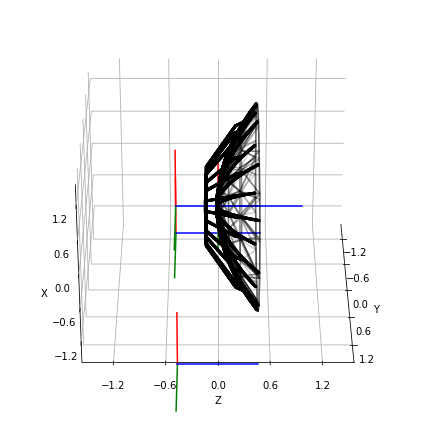

In [12]:
                        #Para obtener las matrices de transformación
# if Frame == "A":
#     Transform =[Rsa,T_sa,T_a]
# if Frame == "B":
#     Transform = [Rab,T_ab,T_sb,T_b]
# if Frame == "C":
#     Transform = [Rcb,T_cb,T_bc,T_ac,T_sc]

    #Para obtener las matrices de transformación para el frame A a 45 azimuth, y 45°elevacion°
Rsa, T_sa,T_a = set_config(45,45,"A")
    #Para obtener las matrices de transformación para el frame B a 45 azimuth, y 45°elevacion°
Rab, T_ab, T_sb,T_b = set_config(45,45,"B")
    #Para obtener las matrices de transformación para el frame C a 45 azimuth, y 45°elevacion°
Rcb,T_cb,T_bc,T_ac,T_sc = set_config(45,45,"C")

                #Para gráficar configuración inicial y configuración con antenna
Initconfig(0,30,"SI")


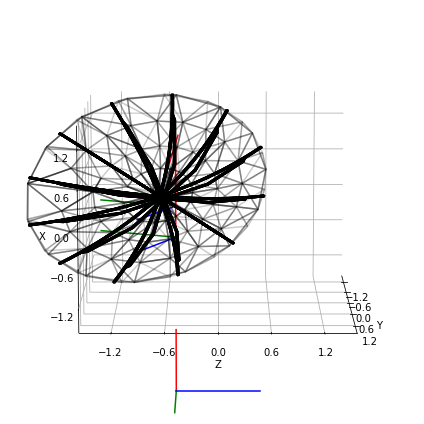

In [13]:
plot_config(115,30,0,10,"SI")

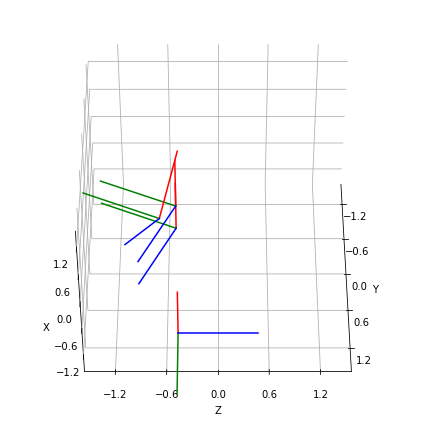

In [14]:
plot_config(115,30,0,45,"NO")

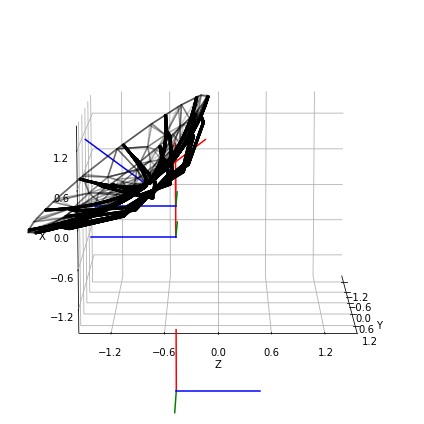

In [15]:
plot_config(180,45,0,10,"SI")

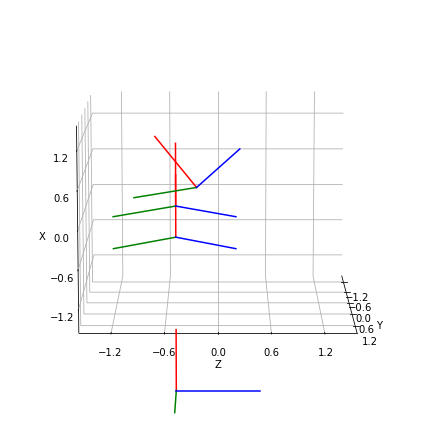

In [16]:
plot_config(45,45,0,10,"NO")

### Carga de datos de Wind Loading

In [17]:
%run C:/Users/David/Documents/Hay_Stack_Radiotelescope_Notebooks/Wind_Loading/Wind_Loading_Functions.ipynb

------------------------------------------DATOS CARGADOS CORRECTAMENTE----------------------------------- 
 Angulos de azimuth alpha:  5 - 180 ,y contiene:  11 
 Angulos de cenitales beta 5 - 90 , y contiene:  7 
 -----------------------------Las cargas en {C} se pueden obtener con las variables:--------------------- 
 Forces_S4 
 Moments_S4 
 Wrench: Es el arreglo que contiene para cada configuración el vector Wrench [Momentos + Fuerzas] 
 New_Wrench: Es un dataframe que contiene el vector Wrench para cada configuración 
             Se puede acceder mediante New_Wrench.loc[beta,alpha]


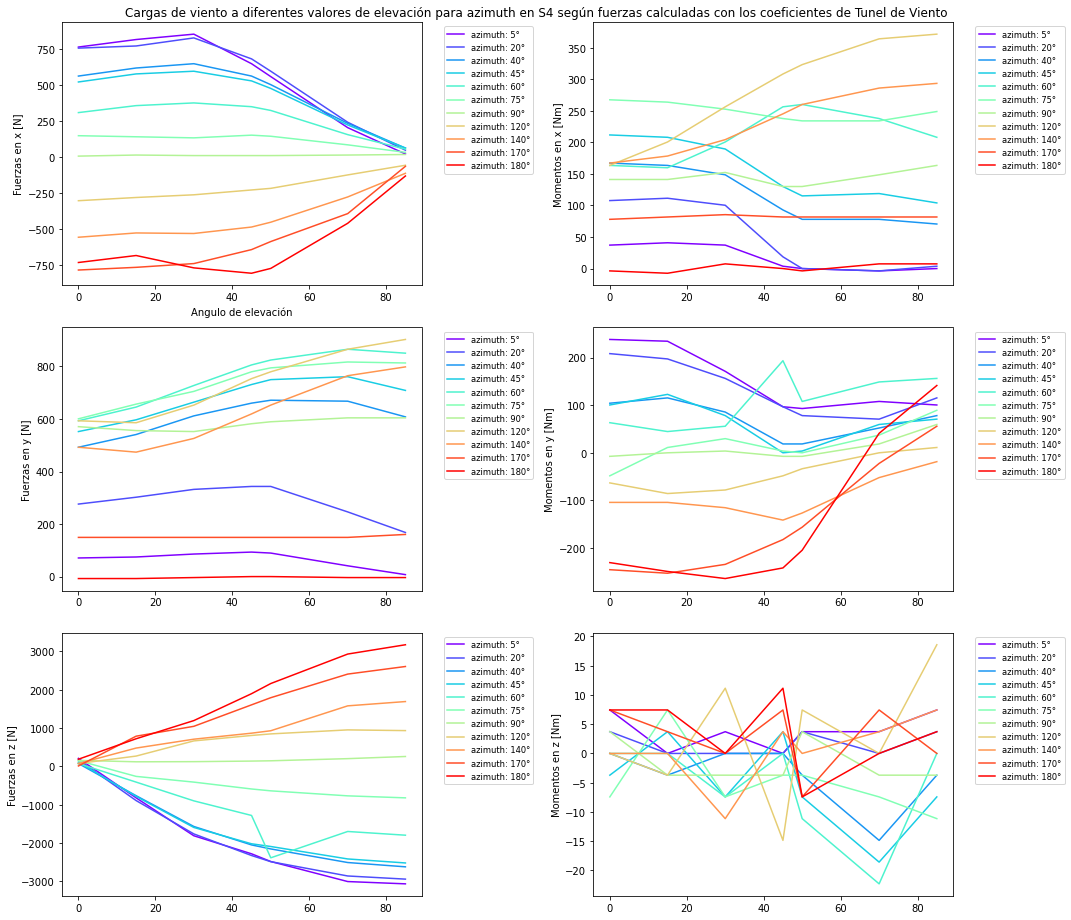

In [18]:
plot_wrench2(search_alpha,search_theta,Forces_S4_TD,Moments_S4_TD,'rainbow', "S4 según fuerzas calculadas con los coeficientes de Tunel de Viento")

# Cargas en el Sistema Coordenado de Cuerpo

In [19]:
search_theta
beta_values

array([85, 70, 50, 45, 30, 15,  0])

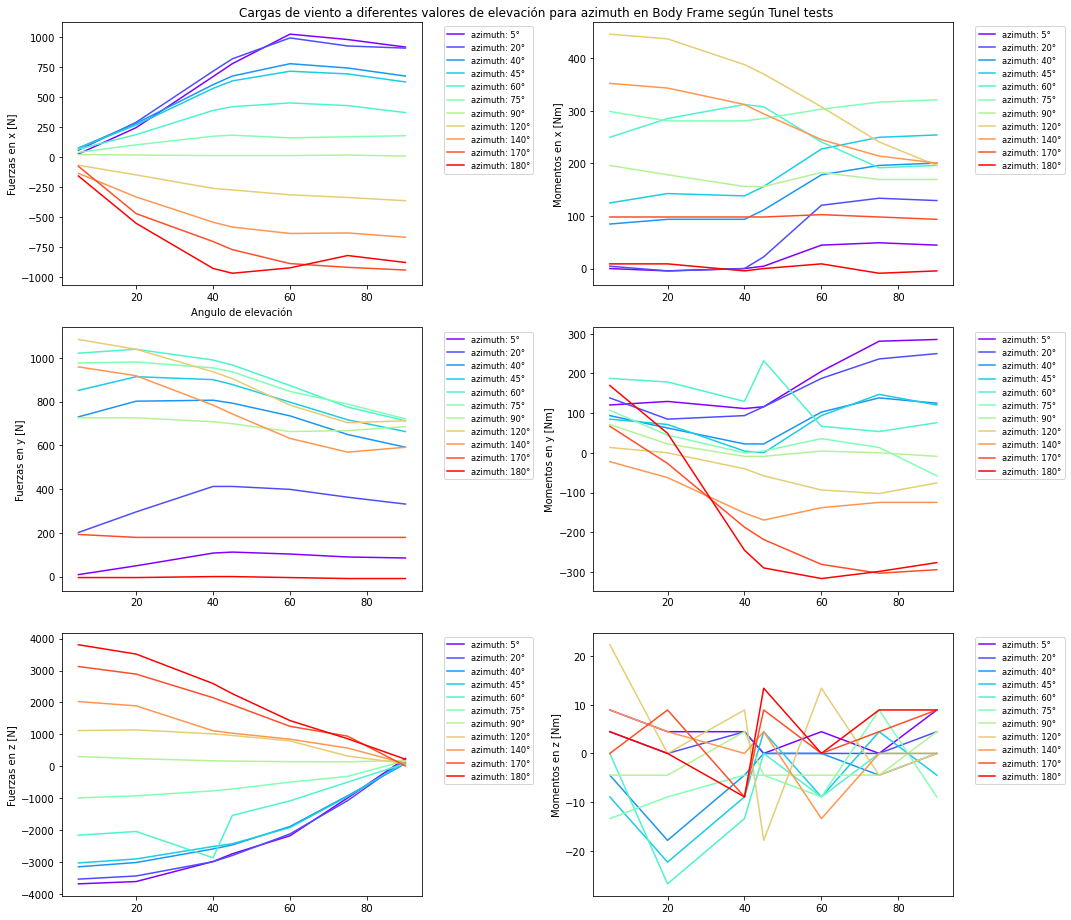

In [20]:
            #Verificación de momentos cálculados con los datos obtenidos en el tunel de viente
#Se crean los momentos en el Frame C, correspondiente a la antena
Forces_C_TD = 1.2*Forces_S4_TD
Moments_C_TD = 1.2*Moments_S4_TD

Wrench_C_TD= Wrench_func(search_alpha,search_theta,Forces_C_TD,Moments_C_TD)
Wrench_CTD_df = Wrenchdf_func(Wrench_C_TD,search_alpha,search_theta)
Wrench_CTD_df.shape
plot_wrench2(search_alpha,beta_values,Forces_C_TD,Moments_C_TD,'rainbow', "Body Frame según Tunel tests") 

#### Carga del peso de la Antena

A continuación se le añade el peso de la antena a las cargas por viento, en este sentido se crea un Wrench en {D} Ant_w = [0,0,0,-w_ant,0,0] y por medio de las matrices de transformación se pasan al sistema coordenado {C}, este estadi de cargas se almacena en un Wrench llamado **Wrench_ant_wind** este Wrench a su vez se carga en dos vectores **Forces_ant_wind** y **Moments_ant_wind**

In [21]:
w_ant = 44.583*10
Ant_w = np.array([0,0,0,-w_ant,0,0])

#Transformación de coordenadas
Wrench_ant_wind = np.empty((len(beta_values),len(search_alpha),6))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        az = search_alpha[j]
        el = 90 - beta_values[i]
        R_cd,T_cd,T_bd = set_config(az,el,"D")
        T_dc = pr_trans.invert_transform(T_cd)
        Adj_Tdc = pr_trans.adjoint_from_transform(T_dc)
        Adj_Tdc_t = Adj_Tdc.T
        Wrench_ant_wind[i,j]= Wrench_C_TD[i,j] + np.dot(Adj_Tdc_t,Ant_w)

Forces_ant_wind = np.empty((len(beta_values),len(search_alpha),3))        
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Forces_ant_wind[i,j] = Wrench_ant_wind[i,j,3:6]
        
        #Creamos el arreglo de momentos
Moments_ant_wind = np.empty((len(beta_values),len(search_alpha),3))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Moments_ant_wind[i,j] = Wrench_ant_wind[i,j,0:3]

#### Valores máximos de carga y momento para cada eje del sistema coordenado de cuerpo C

A partir de la información recolectada en el proceso anterior, se dispone a cálcular las cargas máximas y los momentos máximos en cada eje del sistema coordenado con el fin de tomarlos como valores de diseño, es importante notar que no todos los valores máximos actual a la vez 

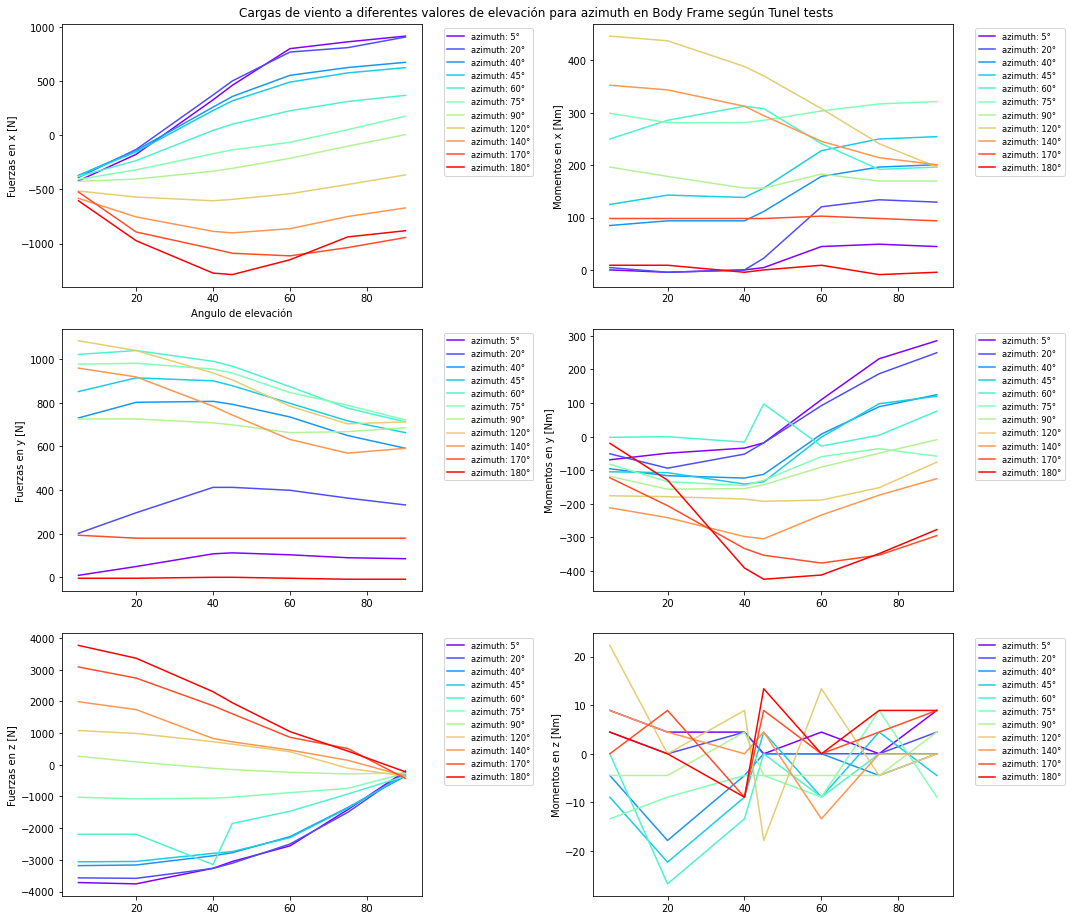

In [22]:
#---------------------------------------------CALCULO DE FUERZAS MÁXIMAS----------------------------
#Cálculo de la carga máxima en el eje x
Forces_MaxFx_c,Moments_MaxFx_c,alpha_MaxFx_c,theta_MaxFx_c= Max_Force(Forces_ant_wind,Moments_ant_wind,0)
#Cálculo de la carga máxima en el eje y
Forces_MaxFy_c,Moments_MaxFy_c,alpha_MaxFy_c,theta_MaxFy_c= Max_Force(Forces_ant_wind,Moments_ant_wind,1)
#Cálculo de la carga máxima en el eje z
Forces_MaxFz_c,Moments_MaxFz_c,alpha_MaxFz_c,theta_MaxFz_c= Max_Force(Forces_ant_wind,Moments_ant_wind,2)

#---------------------------------------------CALCULO DE MOMENTOS MÁXIMoS----------------------------
#Cálculo de los momentos máximos en el eje x 
Forces_MaxMx_c,Moments_MaxMx_c,alpha_MaxMx_c,theta_MaxMx_c= Max_Moments(Forces_ant_wind,Moments_ant_wind,0)
#Cálculo de los momentos máximos en el eje y
Forces_MaxMy_c,Moments_MaxMy_c,alpha_MaxMy_c,theta_MaxMy_c= Max_Moments(Forces_ant_wind,Moments_ant_wind,1)
#Cálculo de los momentos máximos en el eje z
Forces_MaxMz_c,Moments_MaxMz_c,alpha_MaxMz_c,theta_MaxMz_c= Max_Moments(Forces_ant_wind,Moments_ant_wind,2)

plot_wrench2(search_alpha,beta_values,Forces_ant_wind,Moments_ant_wind,'rainbow', "Body Frame según Tunel tests") 


------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN X ----------------- 
 Azimuth:  [180] 
 Elevación:  [45] 
 Fuerza en x:  -1286.841341055839 
 Fuerza en y:  0.0 
 Fuerza en z:  1959.2607118455176 
 Momentos en x:  0.0 
 Momentos en y:  -424.2186341483003 
 Momentos en z:  13.381033053372672 



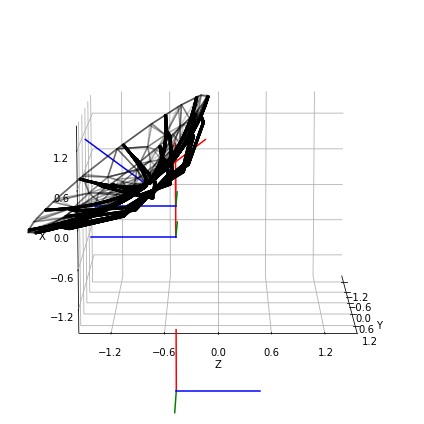

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Y ----------------- 
 Azimuth:  [120] 
 Elevación:  [5] 
 Fuerza en x:  -515.7715965211694 
 Fuerza en y:  1083.526478347763 
 Fuerza en z:  1080.488890694038 
 Momentos en x:  446.0344351124224 
 Momentos en y:  -175.8198303852308 
 Momentos en z:  22.30172175562112 



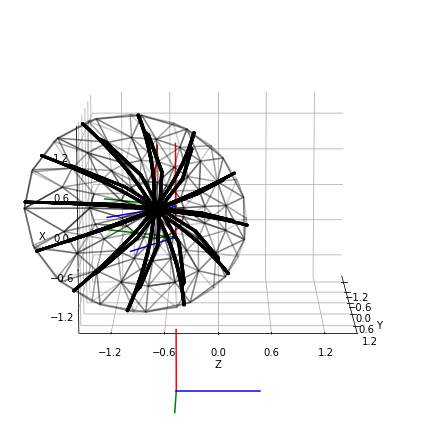

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Z ----------------- 
 Azimuth:  [180] 
 Elevación:  [5] 
 Fuerza en x:  -605.3192393598274 
 Fuerza en y:  -4.477382141932906 
 Fuerza en z:  3766.9181758537807 
 Momentos en x:  8.920688702248448 
 Momentos en y:  -19.707778095882958 
 Momentos en z:  4.460344351124224 



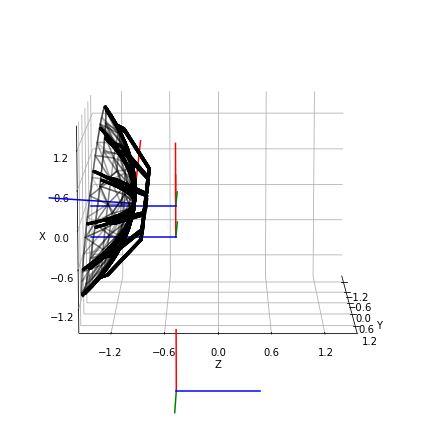

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN X ----------------- 
 Azimuth:  [120] 
 Elevación:  [5] 
 Fuerza en x:  -515.7715965211694 
 Fuerza en y:  1083.526478347763 
 Fuerza en z:  1080.488890694038 
 Momentos en x:  446.0344351124224 
 Momentos en y:  -175.8198303852308 
 Momentos en z:  22.30172175562112 



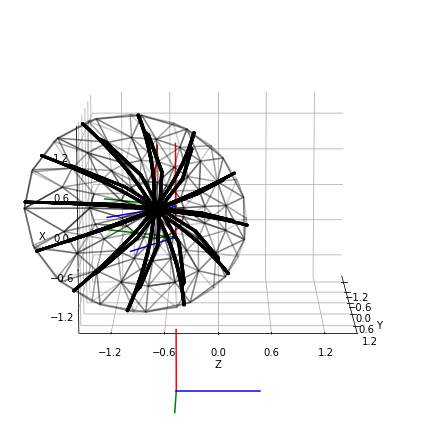

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Y ----------------- 
 Azimuth:  [180] 
 Elevación:  [45] 
 Fuerza en x:  -1286.841341055839 
 Fuerza en y:  0.0 
 Fuerza en z:  1959.2607118455176 
 Momentos en x:  0.0 
 Momentos en y:  -424.2186341483003 
 Momentos en z:  13.381033053372672 



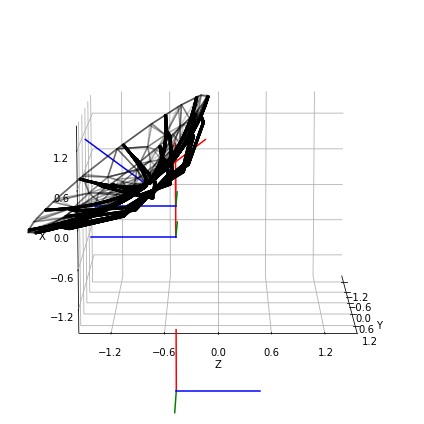

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Z ----------------- 
 Azimuth:  [60] 
 Elevación:  [20] 
 Fuerza en x:  -235.37049330573242 
 Fuerza en y:  1038.7526569284341 
 Fuerza en z:  -2189.6917150783547 
 Momentos en x:  285.46203847195034 
 Momentos en y:  -0.05601259427317018 
 Momentos en z:  -26.762066106745344 



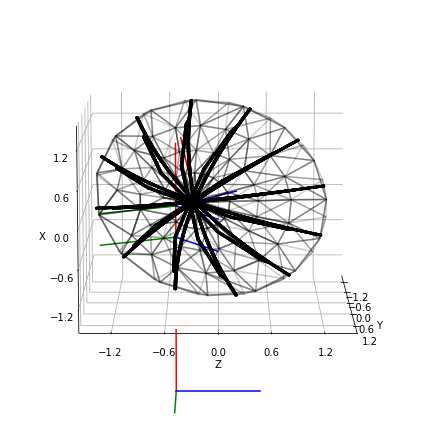

In [23]:
Write_MaxF(Forces_MaxFx_c,Moments_MaxFx_c,alpha_MaxFx_c,theta_MaxFx_c,"FUERZA","X")
Write_MaxF(Forces_MaxFy_c,Moments_MaxFy_c,alpha_MaxFy_c,theta_MaxFy_c,"FUERZA","Y")
Write_MaxF(Forces_MaxFz_c,Moments_MaxFz_c,alpha_MaxFz_c,theta_MaxFz_c,"FUERZA","Z")
Write_MaxF(Forces_MaxMx_c,Moments_MaxMx_c,alpha_MaxMx_c,theta_MaxMx_c,"MOMENTO","X")
Write_MaxF(Forces_MaxMy_c,Moments_MaxMy_c,alpha_MaxMy_c,theta_MaxMy_c,"MOMENTO","Y")
Write_MaxF(Forces_MaxMz_c,Moments_MaxMz_c,alpha_MaxMz_c,theta_MaxMz_c,"MOMENTO","Z")

In [24]:
#Codigo usado para buscar un valor de fuerza dado 
#Direccion x -> i = 0
#Direccion x -> i = 1
#Direccion x -> i = 2 
azimuth_s = 5  #El valor del azimuth
elevacion_s = 5 #El vaor de la elevacion buscada

beta_value = np.where(search_theta == elevacion_s)
alpha_value = np.where(search_alpha== azimuth_s)
beta_value[0][0]
print(Forces_C_TD[beta_value,alpha_value[0][0]])

print(Forces_ant_wind[beta_value,alpha_value[0][0]])




[[[   22.38691071     8.95476428 -3675.93073853]]]
[[[ -421.74657154     8.95476428 -3714.78738332]]]


# Cargas en el sistema coordenado de Elevación

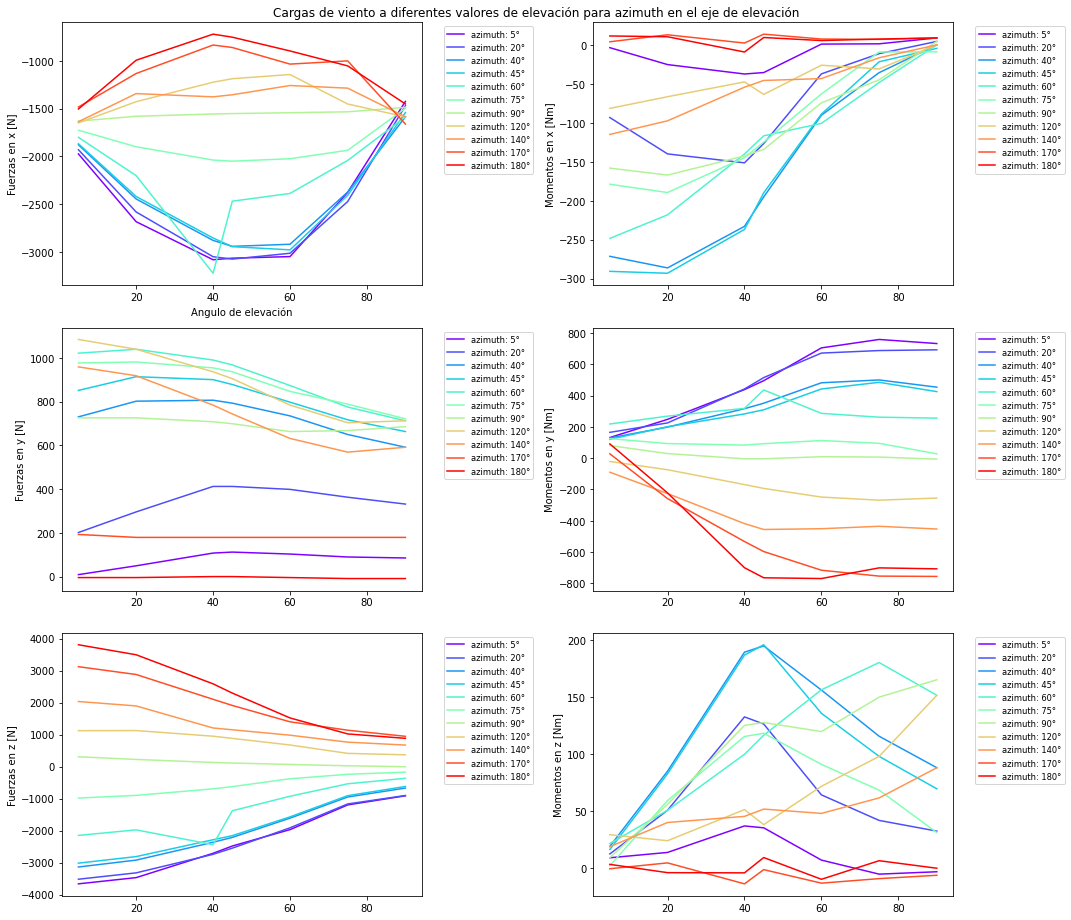

In [25]:
#Se transforma los Wrench en C a B ( eje de elevación) a partir de 
#Rcb,T_cb,T_bc,T_ac,T_sc = set_config(45,45,"C") 

Wrench_B = np.empty((len(beta_values),len(search_alpha),6))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        az = search_alpha[j]
        el = 90 - beta_values[i]
        Rcb,T_cb,T_bc,T_ac,T_sc = set_config(az,el,"C")
        Adj_Tcb = pr_trans.adjoint_from_transform(T_cb)
        Adj_Tcb_t = Adj_Tcb.T
        Wrench_B[i,j]= np.dot(Adj_Tcb_t,Wrench_C_TD[i,j])

for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Wrench_B[i,j,3] = Wrench_B[i,j,3] - 167.59*10
        
        #Creamos el arreglo de fuerzas
Forces_B = np.empty((len(beta_values),len(search_alpha),3))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Forces_B[i,j] = Wrench_B[i,j,3:6]
        
        #Creamos el arreglo de momentos
Moments_B = np.empty((len(beta_values),len(search_alpha),3))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Moments_B[i,j] = Wrench_B[i,j,0:3]
Wrench_B_df = Wrenchdf_func(Wrench_B,search_alpha,beta_values)

plot_wrench2(search_alpha,beta_values,Forces_B,Moments_B,'rainbow', "el eje de elevación")    

In [26]:
#Codigo usado para buscar un valor de fuerza dado 
#Direccion x -> i = 0
#Direccion x -> i = 1
#Direccion x -> i = 2 
azimuth_s = 5  #El valor del azimuth
elevacion_s = 85 #El vaor de la elevacion buscada
beta_value = np.where(beta_values == elevacion_s)
alpha_value = np.where(search_alpha== azimuth_s)
beta_value[0][0]
Forces_B[beta_value[0][0],alpha_value[0][0]]
Forces_B[-1,0]


array([-1425.16660005,    85.0702607 ,  -913.38595695])

#### Valores máximos de carga y momento para cada eje del sistema coordenado de elevación 

A partir de la información recolectada en el proceso anterior, se dispone a cálcular las cargas máximas y los momentos máximos en cada eje del sistema coordenado con el fin de tomarlos como valores de diseño, es importante notar que no todos los valores máximos actual a la vez 

In [27]:
#---------------------------------------------CALCULO DE FUERZAS MÁXIMAS----------------------------
#Cálculo de la carga máxima en el eje x
Forces_MaxFx_b,Moments_MaxFx_b,alpha_MaxFx_b,theta_MaxFx_b= Max_Force(Forces_B,Moments_B,0)
#Cálculo de la carga máxima en el eje y
Forces_MaxFy_b,Moments_MaxFy_b,alpha_MaxFy_b,theta_MaxFy_b= Max_Force(Forces_B,Moments_B,1)
#Cálculo de la carga máxima en el eje z
Forces_MaxFz_b,Moments_MaxFz_b,alpha_MaxFz_b,theta_MaxFz_b= Max_Force(Forces_B,Moments_B,2)

#---------------------------------------------CALCULO DE MOMENTOS MÁXIMoS----------------------------
#Cálculo de los momentos máximos en el eje x 
Forces_MaxMx_b,Moments_MaxMx_b,alpha_MaxMx_b,theta_MaxMx_b= Max_Moments(Forces_B,Moments_B,0)
#Cálculo de los momentos máximos en el eje y
Forces_MaxMy_b,Moments_MaxMy_b,alpha_MaxMy_b,theta_MaxMy_b= Max_Moments(Forces_B,Moments_B,1)
#Cálculo de los momentos máximos en el eje z
Forces_MaxMz_b,Moments_MaxMz_b,alpha_MaxMz_b,theta_MaxMz_b= Max_Moments(Forces_B,Moments_B,2)


------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN X ----------------- 
 Azimuth:  [60] 
 Elevación:  [40] 
 Fuerza en x:  -3219.9765446006186 
 Fuerza en y:  989.5014533671721 
 Fuerza en z:  -2439.1977961623734 
 Momentos en x:  -140.086643848332 
 Momentos en y:  317.6418147794489 
 Momentos en z:  100.07895309932951 



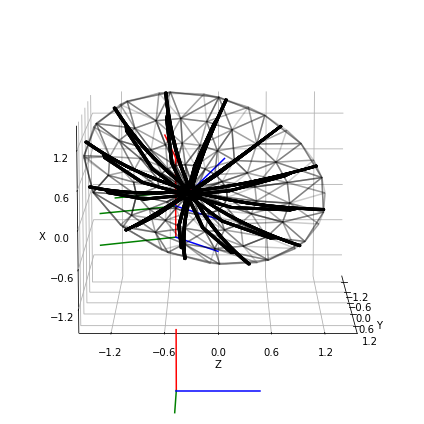

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Y ----------------- 
 Azimuth:  [120] 
 Elevación:  [5] 
 Fuerza en x:  -1649.708118081672 
 Fuerza en y:  1083.526478347763 
 Fuerza en z:  1121.32976083938 
 Momentos en x:  -81.54736727383367 
 Momentos en y:  -21.650004825110383 
 Momentos en z:  29.521380886509903 



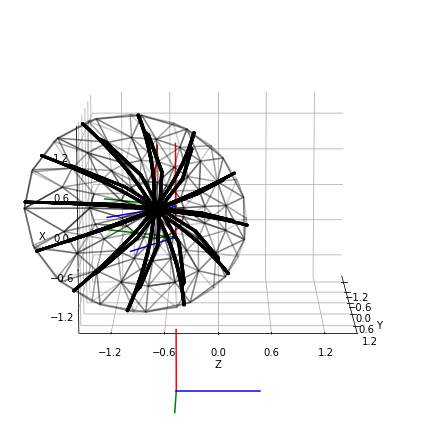

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Z ----------------- 
 Azimuth:  [180] 
 Elevación:  [5] 
 Fuerza en x:  -1504.777265416999 
 Fuerza en y:  -4.477382141932906 
 Fuerza en z:  3805.340962836819 
 Momentos en x:  11.456595801039137 
 Momentos en y:  90.67325011613367 
 Momentos en z:  3.47505988674328 



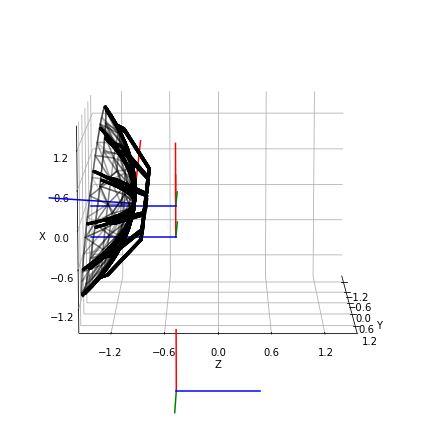

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN X ----------------- 
 Azimuth:  [45] 
 Elevación:  [20] 
 Fuerza en x:  -2418.452194000706 
 Fuerza en y:  913.3859569543126 
 Fuerza en z:  -2812.513772643336 
 Momentos en x:  -293.21405189721685 
 Momentos en y:  200.54246179489382 
 Momentos en z:  82.988190578898 



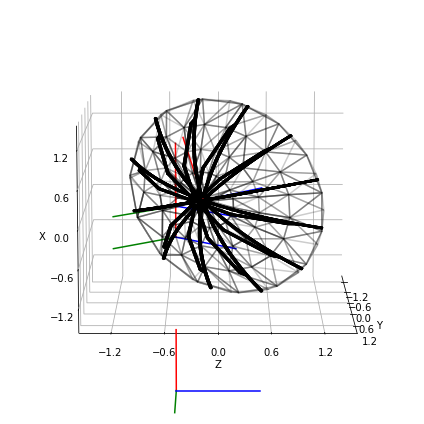

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Y ----------------- 
 Azimuth:  [180] 
 Elevación:  [60] 
 Fuerza en x:  -898.5005149333588 
 Fuerza en y:  -4.477382141932906 
 Fuerza en z:  1519.0291649237538 
 Momentos en x:  5.555064284826823 
 Momentos en y:  -769.8985014826943 
 Momentos en z:  -9.62165358063132 



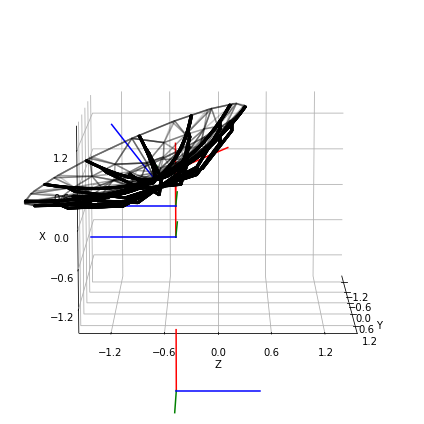

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Z ----------------- 
 Azimuth:  [45] 
 Elevación:  [45] 
 Fuerza en x:  -2942.2949098097233 
 Fuerza en y:  877.5668998188495 
 Fuerza en z:  -2159.2033212255774 
 Momentos en x:  -189.89905380365383 
 Momentos en y:  308.7110213041318 
 Momentos en z:  196.20693327786793 



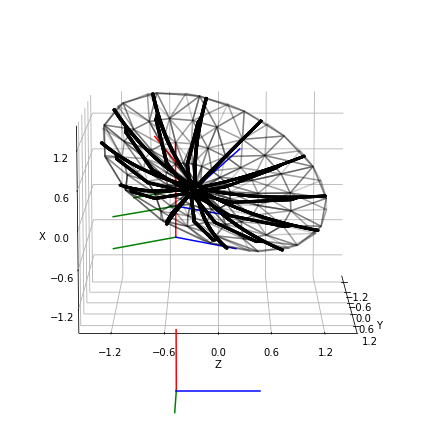

In [28]:
Write_MaxF(Forces_MaxFx_b,Moments_MaxFx_b,alpha_MaxFx_b,theta_MaxFx_b,"FUERZA","X")
Write_MaxF(Forces_MaxFy_b,Moments_MaxFy_b,alpha_MaxFy_b,theta_MaxFy_b,"FUERZA","Y")
Write_MaxF(Forces_MaxFz_b,Moments_MaxFz_b,alpha_MaxFz_b,theta_MaxFz_b,"FUERZA","Z")
Write_MaxF(Forces_MaxMx_b,Moments_MaxMx_b,alpha_MaxMx_b,theta_MaxMx_b,"MOMENTO","X")
Write_MaxF(Forces_MaxMy_b,Moments_MaxMy_b,alpha_MaxMy_b,theta_MaxMy_b,"MOMENTO","Y")
Write_MaxF(Forces_MaxMz_b,Moments_MaxMz_b,alpha_MaxMz_b,theta_MaxMz_b,"MOMENTO","Z")

# Cargas en el sistema coordenado del azimut A

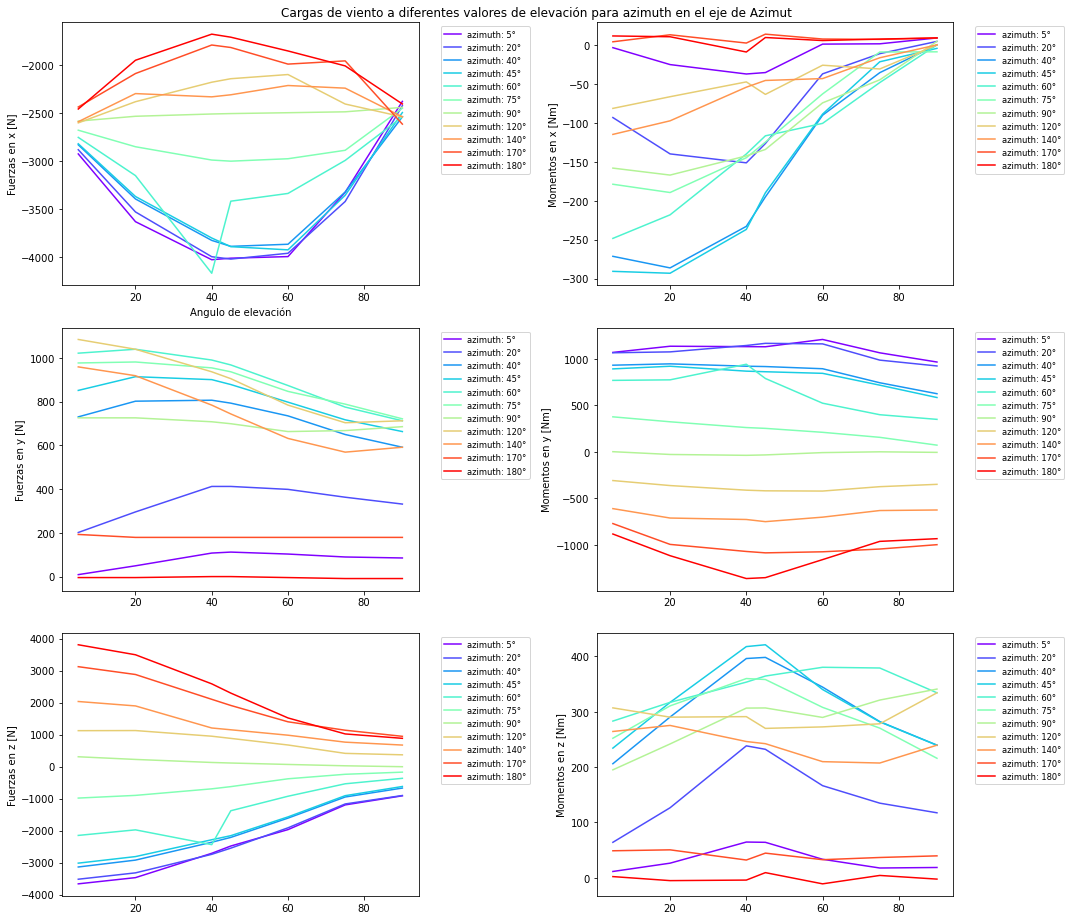

In [29]:

Wrench_A = np.empty((len(beta_values),len(search_alpha),6))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        az = search_alpha[j]
        el = 90 - beta_values[i]
        Rab,T_ab,T_sb,T_b = set_config(az,el,"B")
        T_ba = pr_trans.invert_transform(T_ab)
        Adj_Tba = pr_trans.adjoint_from_transform(T_ba)
        Adj_Tba_t = Adj_Tba.T
        Wrench_A[i,j]= np.dot(Adj_Tba_t,Wrench_B[i,j])

for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Wrench_A[i,j,3] = Wrench_A[i,j,3] - 95*10
        
        #Creamos el arreglo de fuerzas
Forces_A = np.empty((len(beta_values),len(search_alpha),3))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Forces_A[i,j] = Wrench_A[i,j,3:6]
        
        #Creamos el arreglo de momentos
Moments_A = np.empty((len(beta_values),len(search_alpha),3))
for i in range(len(beta_values)):
    for j in range(len(search_alpha)):
        Moments_A[i,j] = Wrench_A[i,j,0:3]
Wrench_A_df = Wrenchdf_func(Wrench_A,search_alpha,beta_values)

plot_wrench2(search_alpha,beta_values,Forces_A,Moments_A,'rainbow', "el eje de Azimut")    

In [30]:
#---------------------------------------------CALCULO DE FUERZAS MÁXIMAS----------------------------
#Cálculo de la carga máxima en el eje x
Forces_MaxFx_a,Moments_MaxFx_a,alpha_MaxFx_a,theta_MaxFx_a= Max_Force(Forces_A,Moments_A,0)
#Cálculo de la carga máxima en el eje y
Forces_MaxFy_a,Moments_MaxFy_a,alpha_MaxFy_a,theta_MaxFy_a= Max_Force(Forces_A,Moments_A,1)
#Cálculo de la carga máxima en el eje z
Forces_MaxFz_a,Moments_MaxFz_a,alpha_MaxFz_a,theta_MaxFz_a= Max_Force(Forces_A,Moments_A,2)

#---------------------------------------------CALCULO DE MOMENTOS MÁXIMoS----------------------------
#Cálculo de los momentos máximos en el eje x 
Forces_MaxMx_a,Moments_MaxMx_a,alpha_MaxMx_a,theta_MaxMx_a= Max_Moments(Forces_A,Moments_A,0)
#Cálculo de los momentos máximos en el eje y
Forces_MaxMy_a,Moments_MaxMy_a,alpha_MaxMy_a,theta_MaxMy_a= Max_Moments(Forces_A,Moments_A,1)
#Cálculo de los momentos máximos en el eje z
Forces_MaxMz_a,Moments_MaxMz_a,alpha_MaxMz_a,theta_MaxMz_a= Max_Moments(Forces_A,Moments_A,2)

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN X ----------------- 
 Azimuth:  [60] 
 Elevación:  [40] 
 Fuerza en x:  -4169.976544600619 
 Fuerza en y:  989.5014533671721 
 Fuerza en z:  -2439.1977961623734 
 Momentos en x:  -140.086643848332 
 Momentos en y:  942.0764505970166 
 Momentos en z:  353.39132516132554 



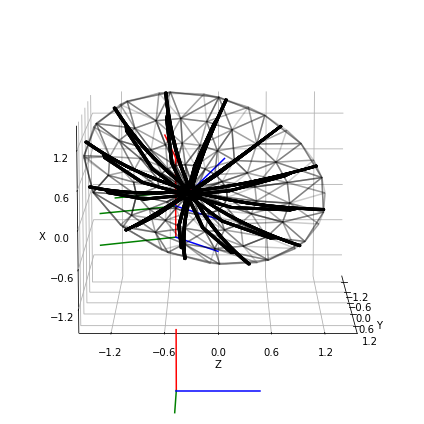

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Y ----------------- 
 Azimuth:  [120] 
 Elevación:  [5] 
 Fuerza en x:  -2599.708118081672 
 Fuerza en y:  1083.526478347763 
 Fuerza en z:  1121.32976083938 
 Momentos en x:  -81.54736727383367 
 Momentos en y:  -308.71042359999166 
 Momentos en z:  306.90415934353723 



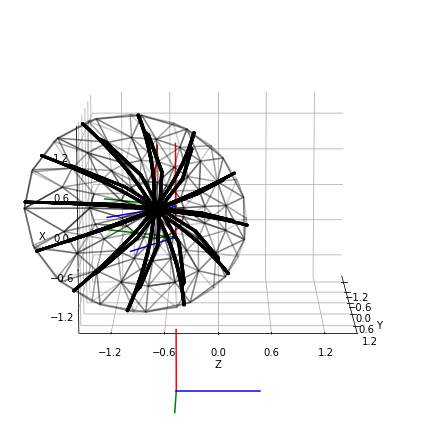

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA FUERZA EN Z ----------------- 
 Azimuth:  [180] 
 Elevación:  [5] 
 Fuerza en x:  -2454.777265416999 
 Fuerza en y:  -4.477382141932906 
 Fuerza en z:  3805.340962836819 
 Momentos en x:  11.456595801039137 
 Momentos en y:  -883.494036370092 
 Momentos en z:  2.328850058408456 



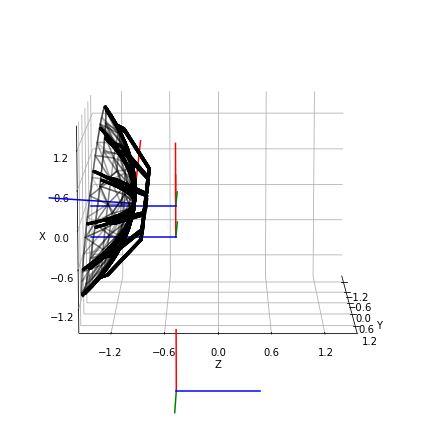

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN X ----------------- 
 Azimuth:  [45] 
 Elevación:  [20] 
 Fuerza en x:  -3368.452194000706 
 Fuerza en y:  913.3859569543126 
 Fuerza en z:  -2812.513772643336 
 Momentos en x:  -293.21405189721685 
 Momentos en y:  920.5459875915878 
 Momentos en z:  316.81499555920203 



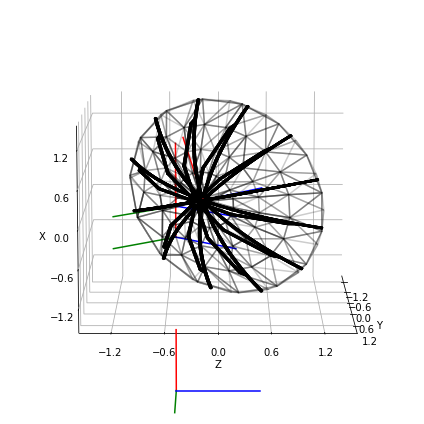

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Y ----------------- 
 Azimuth:  [180] 
 Elevación:  [40] 
 Fuerza en x:  -1672.948393844194 
 Fuerza en y:  0.0 
 Fuerza en z:  2584.5220768787844 
 Momentos en x:  -9.150930172251833 
 Momentos en y:  -1362.360083413081 
 Momentos en z:  -3.9665899253136727 



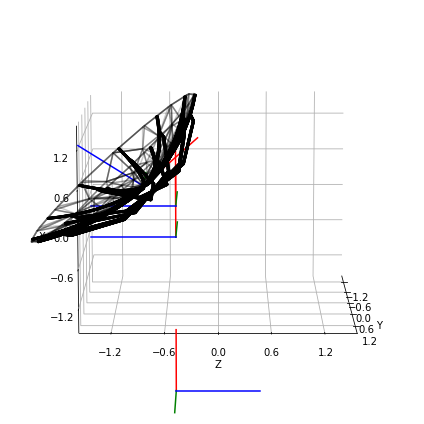

------------------------------------ESTADO DE CARGA PARA LA MÁXIMA MOMENTO EN Z ----------------- 
 Azimuth:  [45] 
 Elevación:  [45] 
 Fuerza en x:  -3892.2949098097233 
 Fuerza en y:  877.5668998188495 
 Fuerza en z:  -2159.2033212255774 
 Momentos en x:  -189.89905380365383 
 Momentos en y:  861.4670715378796 
 Momentos en z:  420.86405963149343 



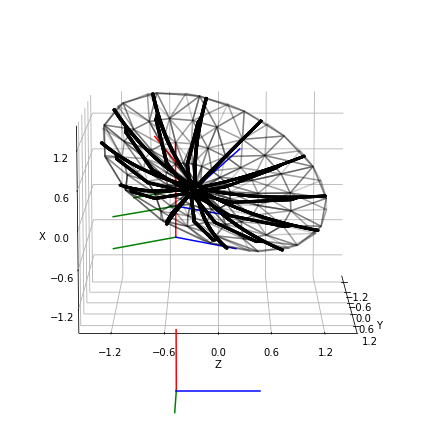

In [31]:
Write_MaxF(Forces_MaxFx_a,Moments_MaxFx_a,alpha_MaxFx_a,theta_MaxFx_a,"FUERZA","X")
Write_MaxF(Forces_MaxFy_a,Moments_MaxFy_a,alpha_MaxFy_a,theta_MaxFy_a,"FUERZA","Y")
Write_MaxF(Forces_MaxFz_a,Moments_MaxFz_a,alpha_MaxFz_a,theta_MaxFz_a,"FUERZA","Z")
Write_MaxF(Forces_MaxMx_a,Moments_MaxMx_a,alpha_MaxMx_a,theta_MaxMx_a,"MOMENTO","X")
Write_MaxF(Forces_MaxMy_a,Moments_MaxMy_a,alpha_MaxMy_a,theta_MaxMy_a,"MOMENTO","Y")
Write_MaxF(Forces_MaxMz_a,Moments_MaxMz_a,alpha_MaxMz_a,theta_MaxMz_a,"MOMENTO","Z")